# CAB420, Regression Summary
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This example revists our regression methods:
* Linear Regression
* Regularised Regression using Ridge (L2 regularisation) and LASSO (L1 regularisation)
* Deep Neural Networks

In this example we'll look at two datasets:
* A dataset of diamond properties and prices
* A dataset of songs

### Diamonds

Here, we'll predict the price of a diamond given some properties. We'll see that on the surface at least, this works fairly well, but there are some issues. 

### Songs

Our second problem in this example is predicting the year of a song's release given some audio features. Essentially, we're regressing from audio features to a year. Sadly, as you'll see the data that doesn't work that well (this is also why we have two datasets). You're not going to see amazing regression results here, and that's ok. The poor performance we observe in this example is due to a few reasons including:
* Weak correlation between the predictors and the response, i.e. we don't have much of a linear relationship to go off. This is a big problem, and one that it's kind of hard to come back from.
* Reducing the dataset size, and dataset imbalance. To avoid long run-times, we're removing a lot of samples. We've also got some fairly massive imbalance in the data. We usually thing of imbalance in terms of classification, but it exists in regression too. Here, what you'll see if our dataset has a bit of an obsession with the late 90's and early 2000's, with most songs being from those years.

### Overall

Hopefully, everything in this example regarding the models themselves will be familar, but if it isn't:
* Ask questions, either in class or online
* Go back and look at the original content in earlier weeks

# CAB420, Regression Summary
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This example revists our regression methods:
* Linear Regression
* Regularised Regression using Ridge (L2 regularisation) and LASSO (L1 regularisation)
* Deep Neural Networks

In this example we'll look at two datasets:
* A dataset of diamond properties and prices
* A dataset of songs

### Diamonds

Here, we'll predict the price of a diamond given some properties. We'll see that on the surface at least, this works fairly well, but there are some issues. 

### Songs

Our second problem in this example is predicting the year of a song's release given some audio features. Essentially, we're regressing from audio features to a year. Sadly, as you'll see the data that doesn't work that well (this is also why we have two datasets). You're not going to see amazing regression results here, and that's ok. The poor performance we observe in this example is due to a few reasons including:
* Weak correlation between the predictors and the response, i.e. we don't have much of a linear relationship to go off. This is a big problem, and one that it's kind of hard to come back from.
* Reducing the dataset size, and dataset imbalance. To avoid long run-times, we're removing a lot of samples. We've also got some fairly massive imbalance in the data. We usually thing of imbalance in terms of classification, but it exists in regression too. Here, what you'll see if our dataset has a bit of an obsession with the late 90's and early 2000's, with most songs being from those years.

### Overall

Hopefully, everything in this example regarding the models themselves will be familar, but if it isn't:
* Ask questions, either in class or online
* Go back and look at the original content in earlier weeks

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
import scipy.stats as stats
import seaborn

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Problem 1: Predicting the Price of Diamonds

We'll start with a simple problem - predicting the price of a rock. We have a dataset from the tensorflow repository for this.

In [2]:
ds_diamonds, ds_info = tfds.load('diamonds',    
    as_supervised=True,
    with_info=True,
)

diamonds = tfds.as_dataframe(ds_diamonds['train'], ds_info)
print(diamonds.dtypes)

features/carat      float32
features/clarity      int64
features/color        int64
features/cut          int64
features/depth      float32
features/table      float32
features/x          float32
features/y          float32
features/z          float32
price               float32
dtype: object


As is always the case, we have some pre-processing to do with the data. In particular, we have three variables (clarify, colour and cut) that are categoricals; and a lot of scale variation across the others (I'll draw a box plot in a bit to prove it). As such, I will:
* Convert colour, cut and clarity to categoricals
* Split the data into train and test
* Standardise the rest of the variables

I will do things in this order to ensure that the categorical conversion is consistent in both train and test sets.

For categorical conversion, I'll first use Pandas' inbuilt categorical type, and then I'll expand each of the categoricals out into sets of columns, such that for each categorical I have N-1 columns (where N is the number of categories). This means that when fitting the regression models, I don't need to worry about flagging which variables are categoricals.

In [3]:
diamonds['features/color'] = pandas.Categorical(diamonds['features/color'])
diamonds['features/cut'] = pandas.Categorical(diamonds['features/cut'])
diamonds['features/clarity'] = pandas.Categorical(diamonds['features/clarity'])
diamonds = pandas.concat([pandas.get_dummies(diamonds['features/color'],prefix='color',drop_first=True), diamonds], axis=1).drop(['features/color'],axis=1)
diamonds = pandas.concat([pandas.get_dummies(diamonds['features/cut'],prefix='cut',drop_first=True), diamonds], axis=1).drop(['features/cut'],axis=1)
diamonds = pandas.concat([pandas.get_dummies(diamonds['features/clarity'],prefix='clarity',drop_first=True), diamonds], axis=1).drop(['features/clarity'],axis=1)
print(diamonds.dtypes)
diamonds_np = diamonds.to_numpy()

clarity_1           uint8
clarity_2           uint8
clarity_3           uint8
clarity_4           uint8
clarity_5           uint8
clarity_6           uint8
clarity_7           uint8
cut_1               uint8
cut_2               uint8
cut_3               uint8
cut_4               uint8
color_1             uint8
color_2             uint8
color_3             uint8
color_4             uint8
color_5             uint8
color_6             uint8
features/carat    float32
features/depth    float32
features/table    float32
features/x        float32
features/y        float32
features/z        float32
price             float32
dtype: object


Now we'll
* Split the data into train, val and test
* Grab the continuous variables and standardise those
* Put the data back together

I don't want to pass the categorical flags through standardisation, so I'll pull those out prior to standardisation, and put them back afterwards.

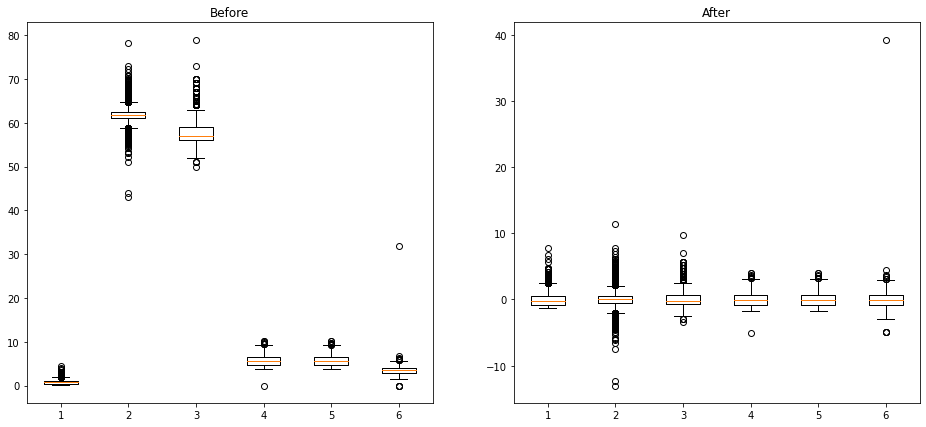

In [4]:
# pull out x and y
X_train = diamonds_np[:, 0:-1]
y_train = diamonds_np[:, -1].reshape(-1, 1)
# split data, train and "the rest" first 
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.6, random_state=42)
# now split "the rest" into val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# pull out just the continuous variables, we have 7 clarity flags + 4 cut flags + 6 colour flags = 17 variables we
# don't want to standardise
X_train_cont = X_train[:, 17:]
X_val_cont = X_val[:, 17:]
X_test_cont = X_test[:, 17:]

# plot a box plot to prove a point
fig = plt.figure(figsize=[16, 7])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X_train_cont)
ax.set_title('Before')

# set up scalers
x_scaler = StandardScaler().fit(X_train_cont)
y_scaler = StandardScaler().fit(y_train)

# standardise
X_train_std = numpy.hstack([X_train[:,0:17], x_scaler.transform(X_train_cont)])
# and a box plot to show what we did
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X_train_std[:, 17:])
ax.set_title('After')
y_train_std = y_scaler.transform(y_train)
X_val_std = numpy.hstack([X_val[:,0:17], x_scaler.transform(X_val_cont)])
y_val_std = y_scaler.transform(y_val)
X_train_std = numpy.hstack([X_train[:,0:17], x_scaler.transform(X_train_cont)])
X_test_std = numpy.hstack([X_test[:,0:17], x_scaler.transform(X_test_cont)])
y_test_std = y_scaler.transform(y_test)

We can clearly see that the original data has some scale variation (told you so), and we've corrected for this. On to regression.

## Linear Regression

We'll start simple, linear regression.

In [5]:
linear_model = sm.OLS(y_train_std, X_train_std).fit()
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              9807.
Date:                Mon, 23 Jan 2023   Prob (F-statistic):                        0.00
Time:                        13:20:32   Log-Likelihood:                         -4299.2
No. Observations:               21576   AIC:                                      8644.
Df Residuals:                   21553   BIC:                                      8828.
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

By and large, the above looks pretty good.

We have a very strong $R^2$ of over $0.9. Most of our terms are significant too. Looking at the correlation between predictors and the response (remember that the first 17 terms are our categorical flags, so don't pay too much attention to those), we see that this poor p-value is likely due to the co-linearity, but we have a number of terms with a very strong relationship with the response.

<AxesSubplot:>

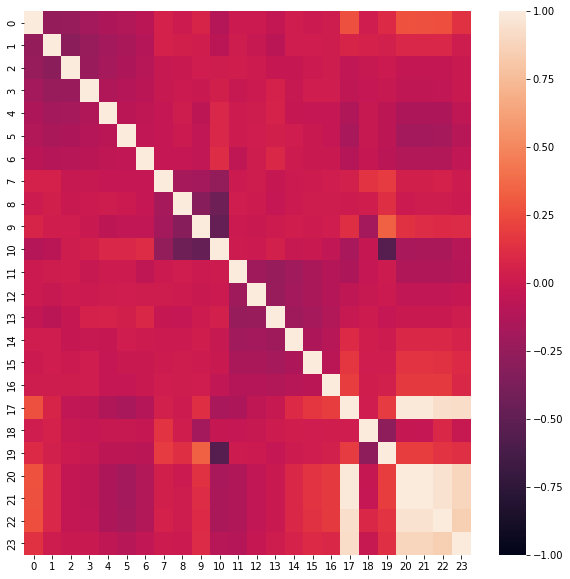

In [6]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
# concat X and y so that we get correlations between pairs of predictors, and correlations between 
# predictors and the response. As we've put these in the order [x, y], our correlations with the
# response will be the last column and row
seaborn.heatmap(numpy.corrcoef(numpy.hstack([X_train, y_train]).transpose()), ax=ax, vmin=-1.0, vmax=1.0)

Looking at the residuals now, we see that all is not as awesome as it perhaps first appeared. 

We have quite a bit of deviation on our qq-plot caused by outlier, essentialy we're getting more points very, very wrong than we should be. We do see that things are fairly symmetrical though, though with the more severe outliers over on the left of the qq-plot and the histogram of residuals, and the lower half of the scatter plot.

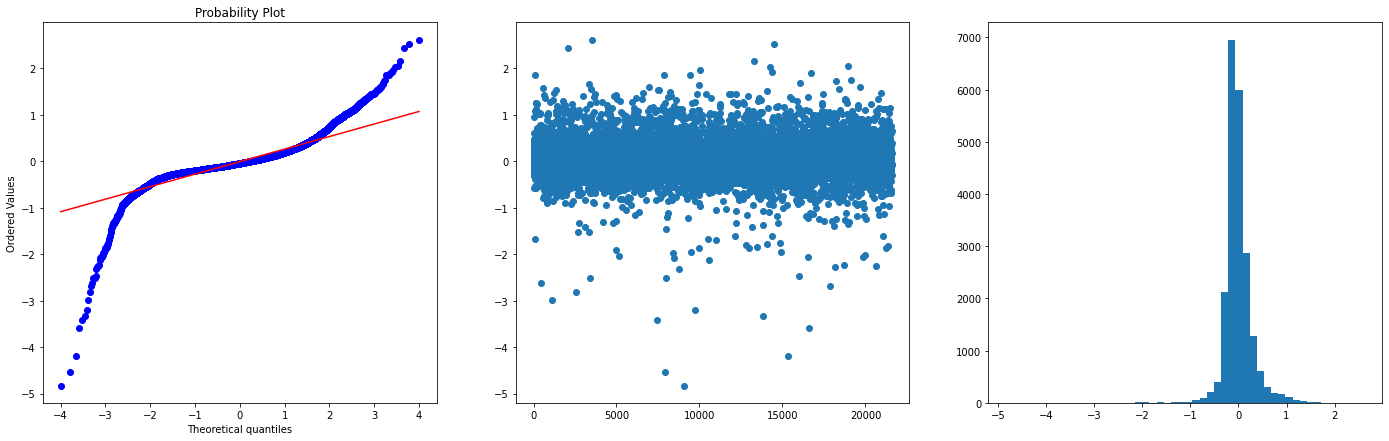

In [7]:
def plot_residuals(residuals):
    fig = plt.figure(figsize=[24, 7])    
    ax = fig.add_subplot(1, 3, 1)
    # qq-plot
    stats.probplot(residuals, dist="norm", plot=ax)
    ax = fig.add_subplot(1, 3, 2)
    # scatter plot of residuals
    ax.scatter(range(len(residuals)), residuals)
    ax = fig.add_subplot(1, 3, 3)
    # histogram of residuals
    ax.hist(residuals, 50)

plot_residuals(linear_model.resid)

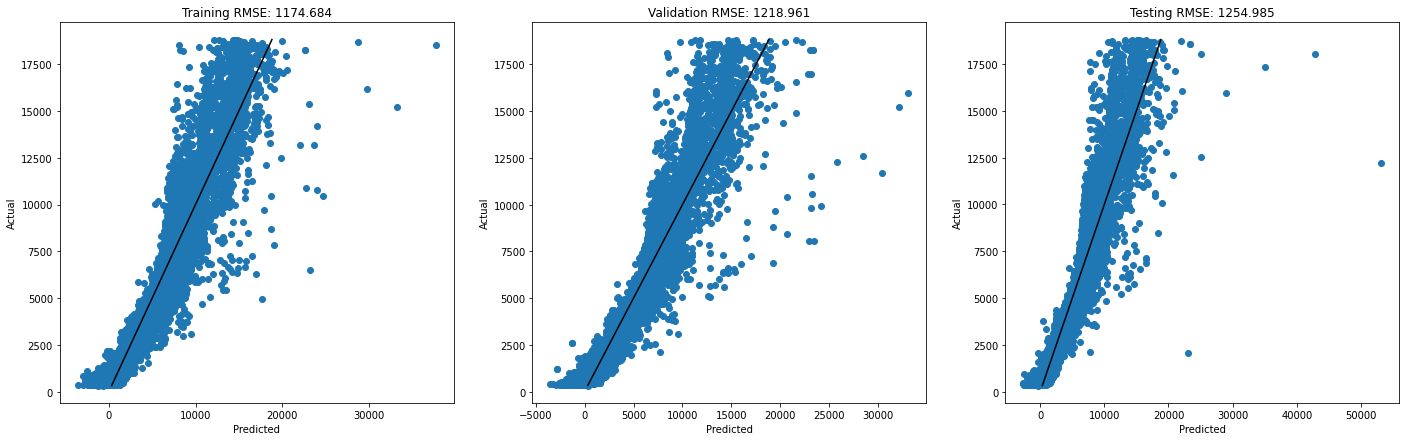

In [8]:
def rmse(y_true, y_pred):
    return numpy.sqrt(numpy.mean((y_true - y_pred)**2))

def plot_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler):
    fig = plt.figure(figsize=[24, 7])

    # plot training predictions vs actual values
    ax = fig.add_subplot(1, 3, 1)    
    # get predictions, pass them through the scaler to transform them back into the 
    # original range
    pred = scaler.inverse_transform(model.predict(X_train).reshape(-1, 1))
    # plot the line of best fit, i.e. the model
    ax.plot(numpy.unique(y_train), numpy.unique(y_train), color='black')
    # scatter of predicted vs actual
    ax.scatter(pred, y_train)
    # get the RMSE
    ax.set_title('Training RMSE: %1.3f' % rmse(y_train, pred))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # repeat the above plot for the validation set
    ax = fig.add_subplot(1, 3, 2)
    pred = scaler.inverse_transform(model.predict(X_val).reshape(-1, 1))
    ax.plot(numpy.unique(y_val), numpy.unique(y_val), color='black')
    ax.scatter(pred, y_val)
    ax.set_title('Validation RMSE: %1.3f' % rmse(y_val, pred))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # and again for the test set
    ax = fig.add_subplot(1, 3, 3)
    pred = scaler.inverse_transform(model.predict(X_test).reshape(-1, 1))
    ax.plot(numpy.unique(y_test), numpy.unique(y_test), color='black')
    ax.scatter(pred, y_test)
    ax.set_title('Testing RMSE: %1.3f' % rmse(y_test, pred))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plot_predictions(linear_model, X_train_std, y_train, X_val_std, y_val, X_test_std, y_test, y_scaler)

Looking at the predictions and actual values, we can clearly see the outliers over the right of the plots. There are a few rocks that we are massivley overpricing. Accuracy across the training, validation and test sets is fairly similar, so overfitting seems to not really be an issue. 

The shape of the scatter plot though perhaps tells us something about what's going on. We see a curve in this, suggesting that maybe there's also some sort of higher order interaction at play, which we're not modelling. Adding higher order terms to the model may help this. We won't explore this here, but feel free to try including this and see what happens.

## Ridge Regression

On to regularisation.

I'm going to consider conduct two searches here. I'll start with a coarse search, and then conduct a finer search around that location.

My first search will move in increments of `step_size` to select some semi-optimal lambda. Having found that, I'll do second search around this initial optimal value +/-`step_size`. As such, in my first search I'll start at `step_size` rather than 0. This way, I don't find the optimal value in the first search as 0, and then try to include negative values in my search for lambda in the second search. This approach will still allow 0 to be considered in the fine-grained search.

In [9]:
# fit a regularised regression model using statsmodels. This will train and evaluate the model over all
# supplied values of lambda/alpha, and find the value that miminises the RMSE on the validation set
#  X_train: matrix of predictors for training
#  y_train: responses for training, should be the same length as X_train
#  X_val: matrix of predictors for the validation set
#  y_val: responses for validation, should be the same length as X_val
#  alphas: list of values to try for lambda/alpha
#  L1_wt: weight given to the L1 term. If 0, train a ridge model. If 1, train a LASSO model
# Returns:
#  Model trained with the optimal value of lambda/alpha
#  RMSEs on the training set for each consisdered value of lambda/alpha
#  RMSEs on the validation set for each considered value of lambda/alpha
#  The estimated model coefficents for each considered value of lambda/alpha
#  Optimal value of alpha/lambda
def fit_regularised(X_train, y_train, X_val, y_val, alphas, L1_wt = 0):

    # storage for RMSEs and coefficients
    train_rmse = []
    val_rmse = []
    coeffs = []

    # loop over supplied alphas
    for a in alphas:
        # train the model
        model = sm.OLS(y_train, X_train).fit_regularized(alpha = a, L1_wt = L1_wt)
        # get the RMSEs and coefficients
        train_rmse.append(rmse(y_train, model.predict(X_train).reshape(-1,1)))
        val_rmse.append(rmse(y_val, model.predict(X_val).reshape(-1,1)))
        coeffs.append(model.params)

    # find the index with the best result
    min_idx = numpy.argmin(val_rmse)
    # train the model with the optimal value of lambda
    model = sm.OLS(y_train, X_train).fit_regularized(alpha = alphas[min_idx], L1_wt = L1_wt)
    
    # return
    return model, train_rmse, val_rmse, coeffs, alphas[min_idx]
    
# some plots specific to our regularised model. This will plot the RMSEs vs alpha/lambda, and
# a trace plot of the coefficients as alpha/lambda changes
#  alphas: list of values used for alpha/lambda
#  train_rmse: list of training RMSE values, same length as alphas
#  val_rmse: list of validation RMSE values, same length as alphas
#  coeffs: model coeffients for each value of lambda
def plot_regularised(alphas, train_rmse, val_rmse, coeffs):

    fig = plt.figure(figsize=[20, 8])
    # trainig and validation RMSE plot
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(alphas, train_rmse, label="Training RMSE")
    ax.plot(alphas, val_rmse, label="Validation RMSE")
    # coefficient trace plot
    ax = fig.add_subplot(2, 1, 2)
    ax.plot(alphas, coeffs)

Initial Alpha: 0.000100; Final Alpha: 0.000000


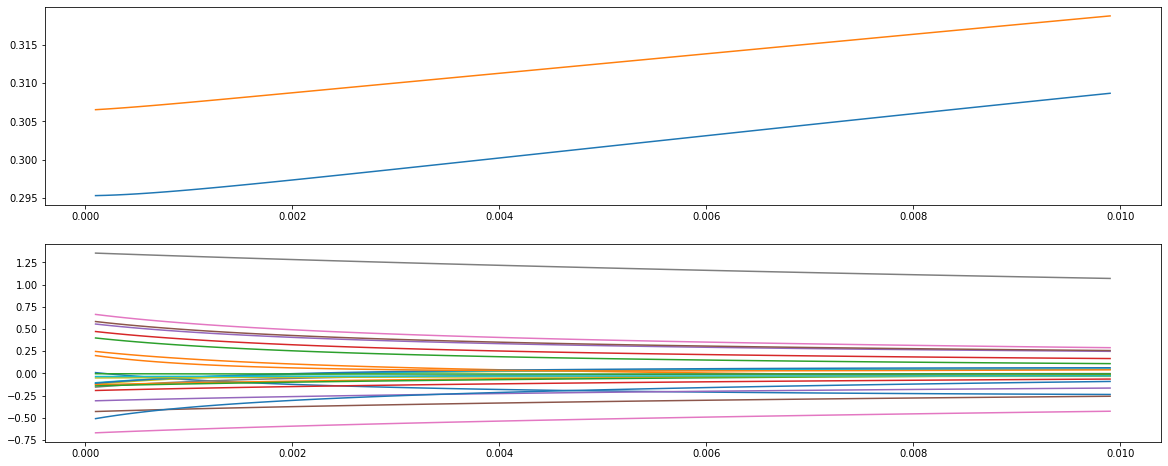

In [10]:
# setup search ranges, coarse search first
min_alpha = 0.0001
max_alpha = 0.01
alpha_step = 0.0001
alphas = numpy.arange(min_alpha, max_alpha, alpha_step)

# conduct coarse search
initial_ridge_model, train_rmse, val_rmse, coeffs, alpha_init = \
    fit_regularised(X_train_std, y_train_std, X_val_std, y_val_std, alphas, 0)
# draw some pictures
plot_regularised(alphas, train_rmse, val_rmse, coeffs)

# fine-grained search
# setup search range, take search around the initial estimate in a much finer grained search
alphas = numpy.arange(alpha_init - alpha_step, alpha_init + alpha_step, alpha_step / 100.0)
# do the search
final_ridge_model, train_rmse, val_rmse, coeffs, alpha = \
    fit_regularised(X_train_std, y_train_std, X_val_std, y_val_std, alphas, 0)
print('Initial Alpha: %f; Final Alpha: %f' % (alpha_init, alpha))

The end result is an optimal $\lambda$ of 0, i.e. no regularisation. As such, our model is the same as the linear model.

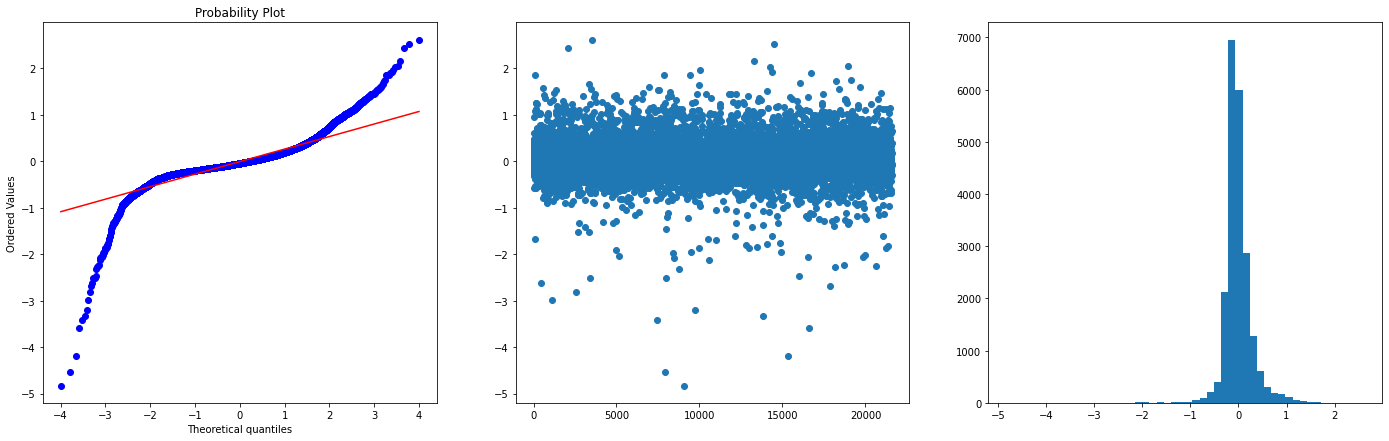

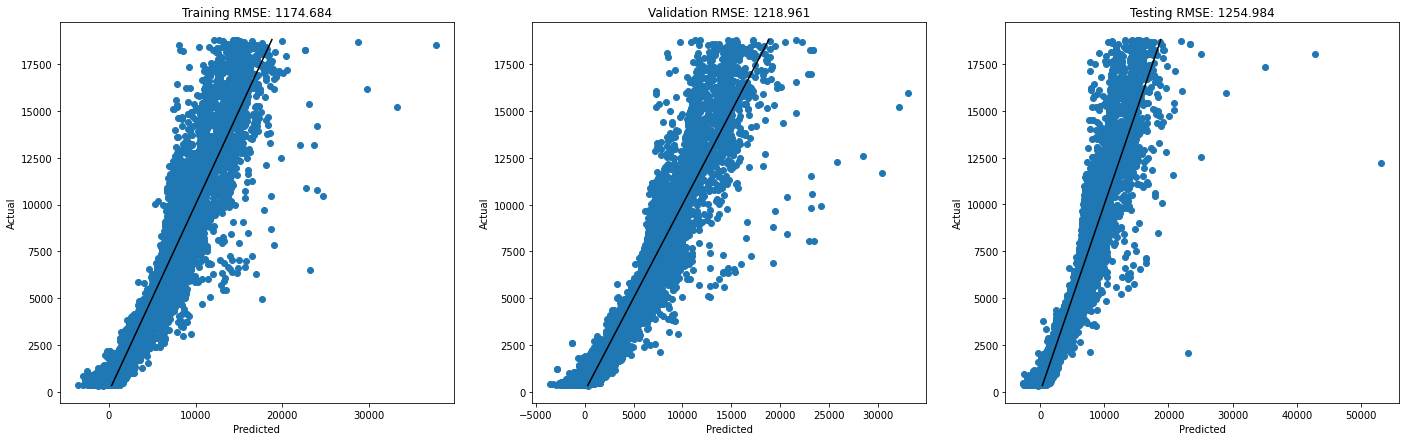

In [11]:
plot_residuals(y_train_std.reshape(-1) - final_ridge_model.predict(X_train_std).reshape(-1))
plot_predictions(final_ridge_model, X_train_std, y_train, \
                 X_val_std, y_val, \
                 X_test_std, y_test, y_scaler)

## LASSO Regularisation

Let's try LASSO now, same setup as before with the coarse and fine searches. Aside from changing our range of possible $\lambda$'s, all we need to do is change the `L1_wt` that we pass into our regularisation function.

Initial Alpha: 0.000200; Final Alpha: 0.000000


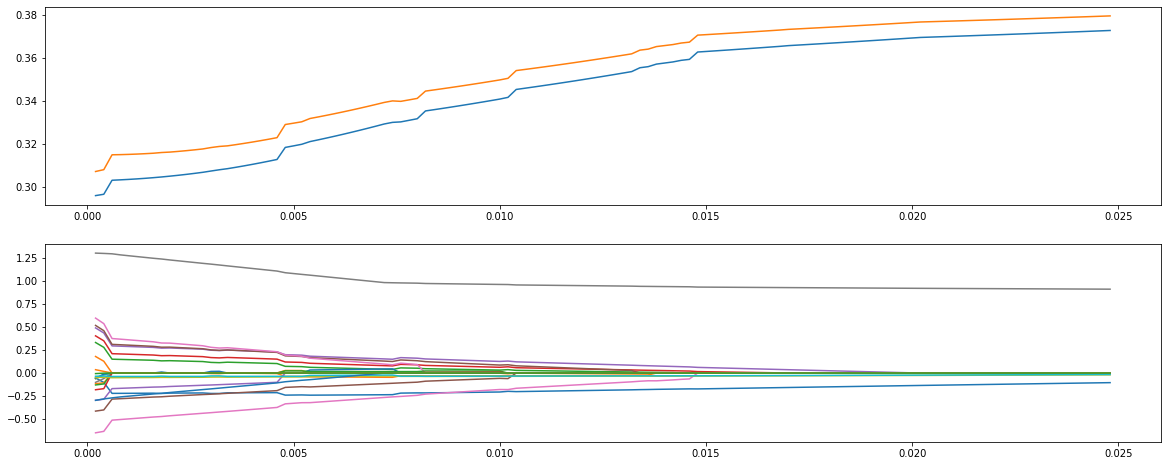

In [12]:
min_alpha = 0.0002
max_alpha = 0.025
alpha_step = 0.0002
alphas = numpy.arange(min_alpha, max_alpha, alpha_step)

initial_lasso_model, train_rmse, val_rmse, coeffs, alpha_init = \
    fit_regularised(X_train_std, y_train_std, X_val_std, y_val_std, alphas, 1)
plot_regularised(alphas, train_rmse, val_rmse, coeffs)

alphas = numpy.arange(alpha_init - alpha_step, alpha_init + alpha_step, alpha_step / 100.0)
final_lasso_model, train_rmse, val_rmse, coeffs, alpha = \
    fit_regularised(X_train_std, y_train_std, X_val_std, y_val_std, alphas, 1)
print('Initial Alpha: %f; Final Alpha: %f' % (alpha_init, alpha))

In [13]:
print('The LASSO model has %d terms removed' % sum(final_lasso_model.params == 0))

The LASSO model has 0 terms removed


And again, regularisation has done nothing.

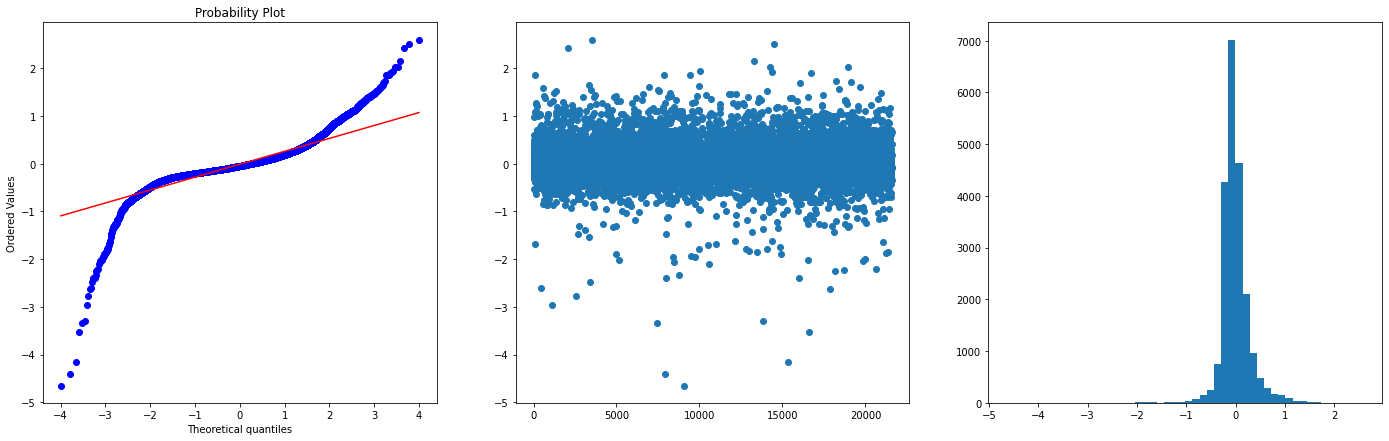

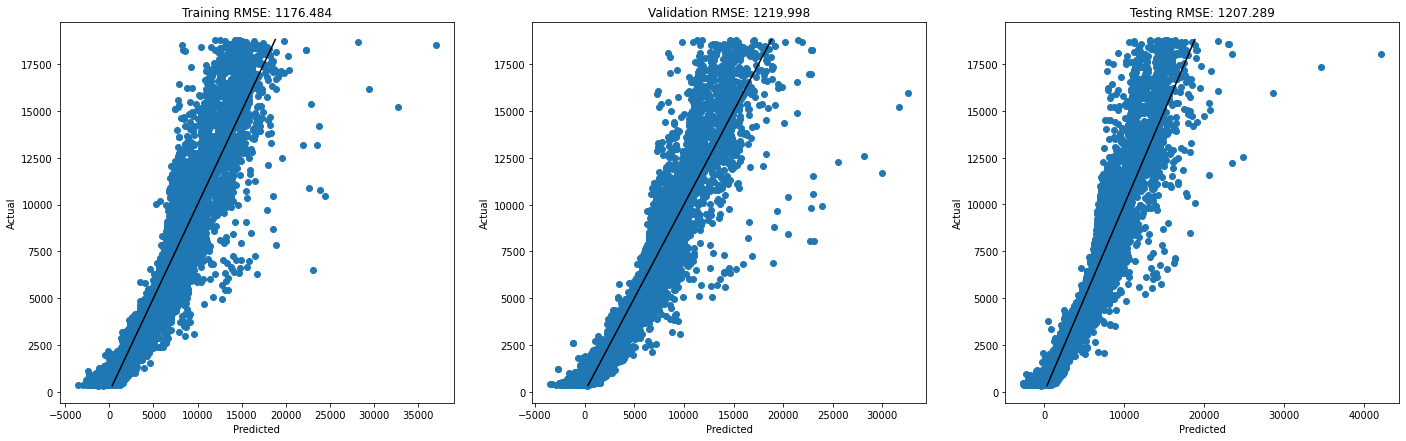

In [14]:
plot_residuals(y_train_std.reshape(-1) - final_lasso_model.predict(X_train_std).reshape(-1))
plot_predictions(final_lasso_model, X_train_std, y_train, \
                 X_val_std, y_val, \
                 X_test_std, y_test, y_scaler)

#### Why doesn't regularisation do anything?

Regularisation is finding the best trade off between variance and bias, and there's nothing to say that regularisation is guaranteed to help. In our case we have:
* Lots of data, over 20,000 training samples
* Not many predictors, just 23, of which 17 are categorical flags
* Some form of relationship (or at least non-zero correlation) between the predictor and response for our 6 continuous variables

When we've previously used regularisation, we've had one or more of lots of redundant terms, overfitting, or a small amount of data. We have none of these, and so we don't see any benefit. If we make $\lambda$ smaller again we may see that we can find a regularised model, but we also may not (go on, try this yourselves).

Above the idea of higher order terms were also mentioned. Likely, if we added higher order terms (which could lead to a small explosion in the number of predictors) we'd likely see that regularisation could help. Again, this something to try yourselves.

## Deep Learning

The linear models we've tried, as the name implies, assume a linear relationship. We'll try a Deep Neural Network now, which makes no such assumptions. Some things to note:
* We're not using any convolutions. This data is tabular data, so we don't have the sort of spatial relationships between consecutive elements like we do in an image or an audio signal.
* The network design is fairly arbitrary. Feel free to play with the layer sizes, number of layers, activations, use of batch normalisation or dropout. 

In [15]:
# input, 23 dimensional vectors
inputs = keras.Input(shape=(23, ), name='inp')
# 3 hidden layers, with 64, 128, and 64 neurons. We're looking to discover patterns/relationships in the data.
# more layers allows us to capture more complex relationships, but increases the risk of overfitting
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
# output layer
outputs = layers.Dense(1)(x)

# build the model and print a summary
model_dnn = keras.Model(inputs=inputs, outputs=outputs, name='song_prediction')
model_dnn.summary()

Model: "song_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 64)                1536      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,177
Trainable params: 18,177
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train the model
model_dnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())

history = model_dnn.fit(X_train_std, y_train_std,
                    batch_size=128,
                    epochs=20,
                    validation_data=(X_val_std, y_val_std))

Epoch 1/20
169/169 [==============================] - 2s 8ms/step - loss: 0.1097 - val_loss: 0.0630
Epoch 2/20
169/169 [==============================] - 1s 7ms/step - loss: 0.0470 - val_loss: 0.0457
Epoch 3/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0399 - val_loss: 0.0391
Epoch 4/20
169/169 [==============================] - 1s 7ms/step - loss: 0.0308 - val_loss: 0.0329
Epoch 5/20
169/169 [==============================] - 1s 7ms/step - loss: 0.0265 - val_loss: 0.0313
Epoch 6/20
169/169 [==============================] - 1s 7ms/step - loss: 0.0241 - val_loss: 0.0248
Epoch 7/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0231 - val_loss: 0.0274
Epoch 8/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0234 - val_loss: 0.0254
Epoch 9/20
169/169 [==============================] - 1s 7ms/step - loss: 0.0218 - val_loss: 0.0232
Epoch 10/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0209 - val_loss: 0.0249

506/506 [==============================] - 1s 2ms/step


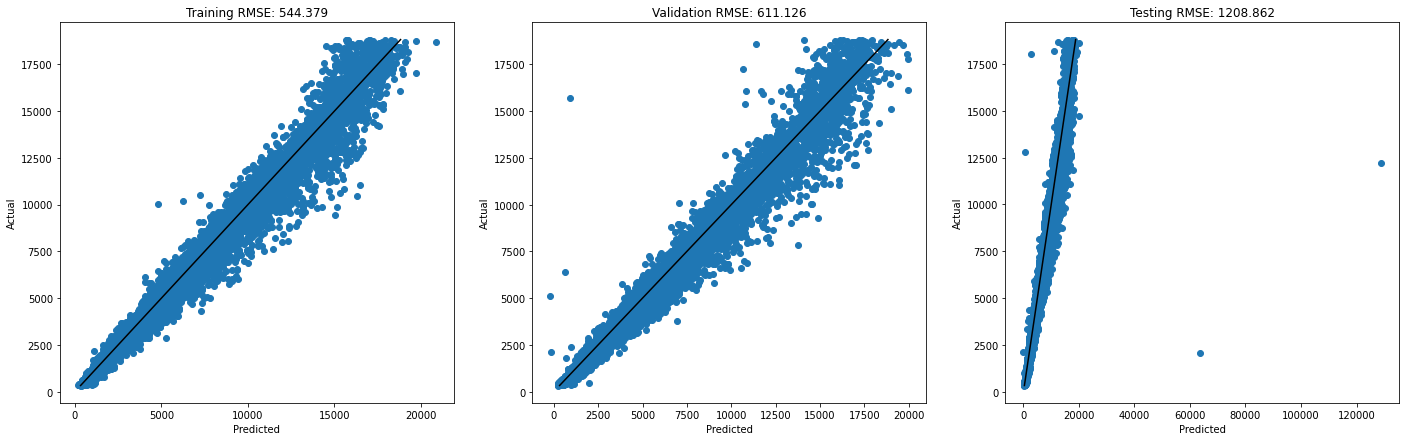

In [17]:
plot_predictions(model_dnn, X_train_std, y_train, \
                 X_val_std, y_val, \
                 X_test_std, y_test, y_scaler)

The DNN is our best model, at least on the training and validation sets. It's made a couple of massive errors on the test set which bring that down, but ignoring those it's done better there too.

There are a few reasons for this:
* We're no longer constrained by our linear assumptions.
* We can now model interactions between the variables via the stacked nature of the model.
* We can better leverage the large amount of data that we have.

In the above I've not looked at the residuals either, the reason being that with a deep net I no longer have any assumptions regarding my residuals, so I don't have any need to check these.

If the above makes it sound like a deep net is the answer to everything here, keep the following in mind:
* If I had less data, this would not go as well.
* Overfitting is more likely to be an issue here, and (perhaps) we're starting to see this in the above. My validation accuracy is best several epochs before the end of training.
* The model cannot be easily explained. With the linear models, I can look at model weights and work out *why* a prediction is off. I can't easily do this here.

# Problem 2: Predicting the Year of a Song's Release

We're using data from the Million Song Dataset here. This doesn't seem like an obvious regression dataset (and it's not an easy choice), but it can be formulated as a regression task where we use the year of the songs release as the response (the thing we're trying to predict), and a bunch of audio features as predictors.

The data has come from [here](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd) if you'd like to read more. Note that we're using a greatly reduced version of the dataset. The original version up on the UCI repository has over 500,000 samples and is ~400MB in size. I have used the following to reduce the data:
```
data = pandas.read_csv('../data/YearPredictionMSD.txt')
data_train = data.iloc[0:463715:80, :]
data_test = data.iloc[463715::50, :]
data_train.to_csv('../data/YearPredictionMSD/msd_train.csv', index=False)
data_test.to_csv('../data/YearPredictionMSD/msd_test.csv', index=False)
```

Note that the file `../data/YearPredictionMSD.txt` is not included in the code repository as it's just a bit big. If you'd like to play with the original data, feel free to grab that from the above link.

As per the dataset instructions, the training data comes from the first 463,715 samples, which ensures that no song from the same artist is in both the train and test sets. Unfortunatley, we don't have the names of the actual songs themselves, though this also means I can't get sidetracked with silly dicsussions of that.

**Note that for this set of data, I'll reuse the same functions implemented above to deal with Problem 1, so the code shown below is fairly compact.**

In [18]:
data_train = pandas.read_csv('../data/YearPredictionMSD/msd_train.csv').to_numpy()
data_test = pandas.read_csv('../data/YearPredictionMSD/msd_test.csv').to_numpy()

### Data Setup

The response (the year of the songs release) is in the first column, the rest are our predictors. The training set will be split into train and validation using sklearn's `train_test_split`. Following the splitting, we'll standardise the data. As per usual, we'll get our mean and std dev on the training set, and use these to standardise all three datasets.

In [19]:
X_train = data_train[:, 1:]
y_train = data_train[:, 0].reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test = data_test[:, 1:]
y_test = data_test[:, 0].reshape(-1, 1)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_std = x_scaler.transform(X_train)
y_train_std = y_scaler.transform(y_train)
X_val_std = x_scaler.transform(X_val)
y_val_std = y_scaler.transform(y_val)
X_test_std = x_scaler.transform(X_test)
y_test_std = y_scaler.transform(y_test)

(4637, 90)
(4637, 1)
(1160, 90)
(1160, 1)
(1033, 90)
(1033, 1)


## Linear Regression

We'll start with linear regression. We have lots of dimensions (90), but many more samples (4,637), so the high number of dimensions is not an issue on it's own. 

In [20]:
linear_model = sm.OLS(y_train_std, X_train_std).fit()
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.253
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              17.10
Date:                Mon, 23 Jan 2023   Prob (F-statistic):                   2.54e-221
Time:                        13:25:43   Log-Likelihood:                         -5903.8
No. Observations:                4637   AIC:                                  1.199e+04
Df Residuals:                    4547   BIC:                                  1.257e+04
Df Model:                          90                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Our linear model is not very good. The $R^2$ is poor at ~0.25, and we seem to have a lot of terms with poor p-values (i.e. greater than 0.05, and thus not statistically significant). 

Prior to fitting our linear model, we did not attempt to remove redundant variables, but with 90 predictors there's a fair chance that some of these are not that much use. Looking at a heat map of the correlation coefficients, we can see that there is some co-linearity in the data.

<AxesSubplot:>

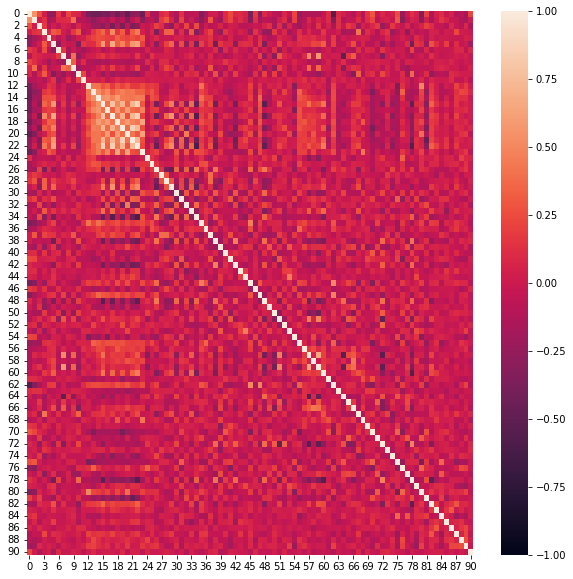

In [21]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
# concat X and y so that we get correlations between pairs of predictors, and correlations between 
# predictors and the response. As we've put these in the order [x, y], our correlations with the
# response will be the last column and row
seaborn.heatmap(numpy.corrcoef(numpy.hstack([X_train, y_train]).transpose()), ax=ax, vmin=-1.0, vmax=1.0)

One thing that that's not obvious from the above, as it's only 1 row/column, is the weak correlations between the predictors and the response. There are no terms that jump out as being strongly related between with the response. This is a problem, and will limit the predictive power of our model.

Let's now consider the residuals. From these we see
* Our qq-plot shows that we don't have normally distributed residuals
* We have skew towards the left of the plot

Finally, we'll explore the actual model predictions to try and understand what's going on.

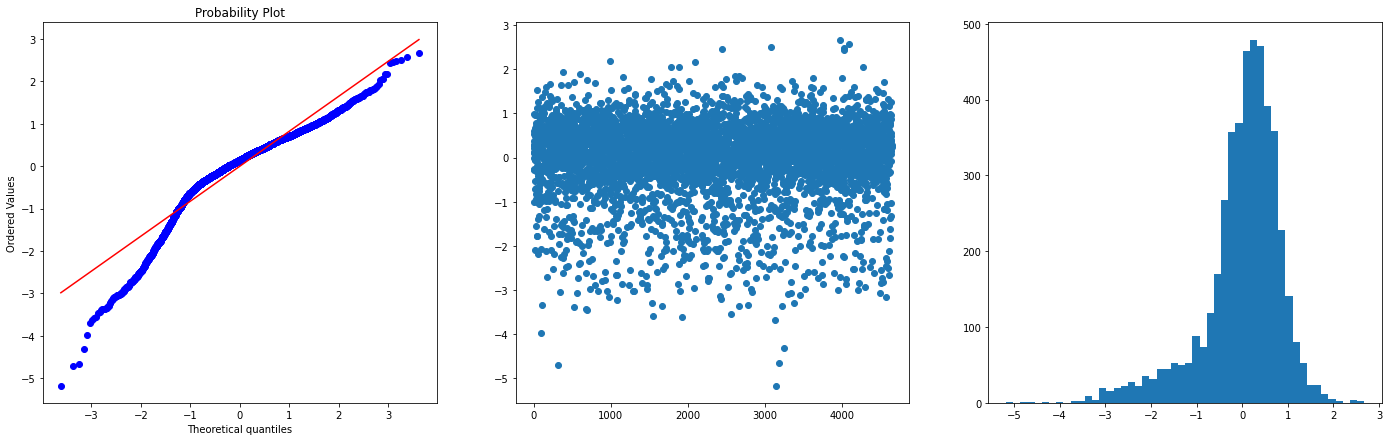

In [22]:
plot_residuals(linear_model.resid)

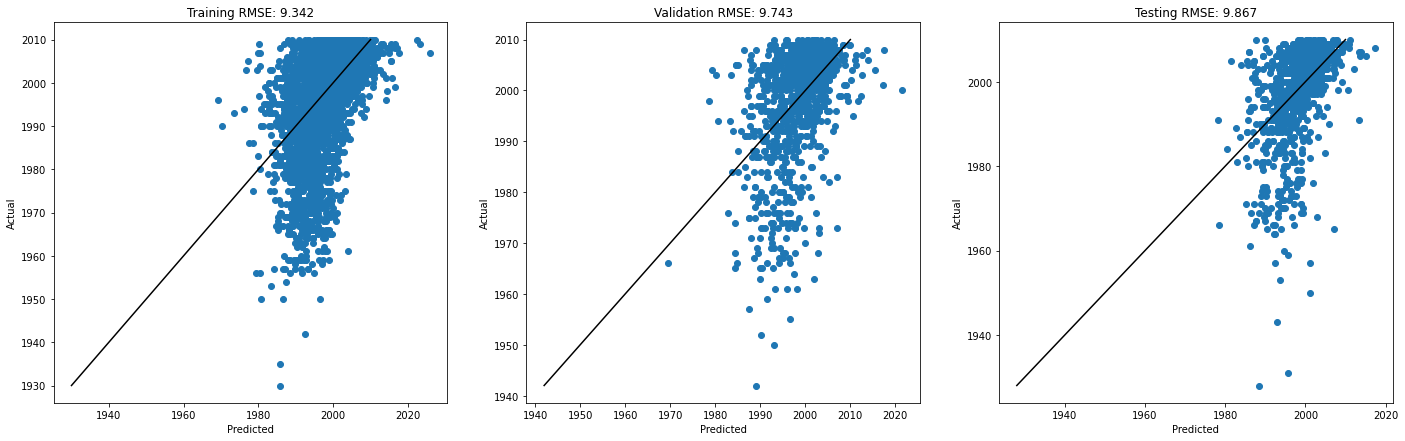

In [23]:
plot_predictions(linear_model, X_train_std, y_train, X_val_std, y_val, X_test_std, y_test, y_scaler)

From the above we can see:
* Our predictions suck, our model is fixated on the 1990's through to the ealry-mid 2000's, predicting most things in that range (is our model actually a commercial radio station?)
* Our model never predicts any song as being earlier than about 1970, yet our data contains songs that go back to the 1930's
* Our data appears to be massively imbalanced, most samples seem to lie from 1970 onwards.

Let's quickly check what's happening with the data distribution.

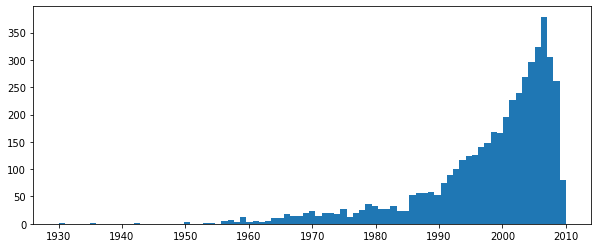

In [24]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(1, 1, 1)
ax.hist(y_train, int(numpy.max(y_train) - numpy.min(y_train) + 1));

This is, fairly clearly, a bit skewed.

What this means though, is that a song released earlier than ~1970 (or even later) is very much a statistical outlier. If we correct for this somewhat, what happens?

Let's just remove all music from pre-1980. Sorry Beatles, Stones, Led Zeppelin, Hendrix, Cream, the Kinks, etc. You're just not relevant to the tick-tock generation.

Note that here I'm going to grab the un-standardised data, and then apply standardisation again, as this filtering will have altered the distribution of the data and thus the estimated mean, std-dev, etc.

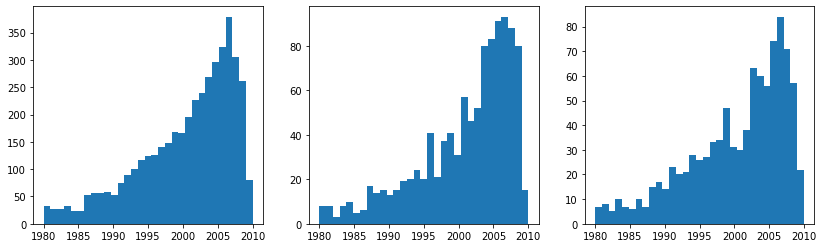

In [25]:
X_train_80s_90s_and_the_new_stuff = X_train[(y_train >= 1980).reshape(-1), :]
y_train_80s_90s_and_the_new_stuff = y_train[(y_train >= 1980)].reshape(-1, 1)
X_val_80s_90s_and_the_new_stuff = X_val[(y_val >= 1980).reshape(-1), :]
y_val_80s_90s_and_the_new_stuff = y_val[(y_val >= 1980)].reshape(-1, 1)
X_test_80s_90s_and_the_new_stuff = X_test[(y_test >= 1980).reshape(-1), :]
y_test_80s_90s_and_the_new_stuff = y_test[(y_test >= 1980)].reshape(-1, 1)

fig = plt.figure(figsize=[14,4])
ax = fig.add_subplot(1, 3, 1)
ax.hist(y_train_80s_90s_and_the_new_stuff, int(numpy.max(y_train_80s_90s_and_the_new_stuff) - numpy.min(y_train_80s_90s_and_the_new_stuff) + 1));
ax = fig.add_subplot(1, 3, 2)
ax.hist(y_val_80s_90s_and_the_new_stuff, int(numpy.max(y_val_80s_90s_and_the_new_stuff) - numpy.min(y_val_80s_90s_and_the_new_stuff) + 1));
ax = fig.add_subplot(1, 3, 3)
ax.hist(y_test_80s_90s_and_the_new_stuff, int(numpy.max(y_test_80s_90s_and_the_new_stuff) - numpy.min(y_test_80s_90s_and_the_new_stuff) + 1));

# all this data is now named 'fm', after all the commercial FM radio stations who draw their playlists
# this same time period
x_scaler_fm = StandardScaler().fit(X_train_80s_90s_and_the_new_stuff)
y_scaler_fm = StandardScaler().fit(y_train_80s_90s_and_the_new_stuff)

X_train_std_fm = x_scaler_fm.transform(X_train_80s_90s_and_the_new_stuff)
y_train_std_fm = y_scaler_fm.transform(y_train_80s_90s_and_the_new_stuff)
X_val_std_fm = x_scaler_fm.transform(X_val_80s_90s_and_the_new_stuff)
y_val_std_fm = y_scaler_fm.transform(y_val_80s_90s_and_the_new_stuff)
X_test_std_fm = x_scaler_fm.transform(X_test_80s_90s_and_the_new_stuff)
y_test_std_fm = y_scaler_fm.transform(y_test_80s_90s_and_the_new_stuff)

Our data is far from perfectly balanced, but it's at least not quite as bad as it was. Before we look at how well this does or doesn't work, let's consider the other approach we could have taken here. Way up at the start of this, I selected every 80th sample from the original dataset. I just did this sequentially. What I could have done, to get roughly the same number of overall samples, was select ~50-70 samples from each year. This would have given a balanced dataset. This would have resolved the data skew problems, but there is another possible problem with this approach. The reality of this data is that there are way more songs in the dataset from 2006 than 1968 (the quality, or overall merits of those songs is a different matter), so an even sampling approach would not actually represent the data correctly, and may lead to better performance on the test set.

In [26]:
linear_model_fm = sm.OLS(y_train_std_fm, X_train_std_fm).fit()
print(linear_model_fm.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.258
Model:                            OLS   Adj. R-squared (uncentered):              0.242
Method:                 Least Squares   F-statistic:                              16.14
Date:                Mon, 23 Jan 2023   Prob (F-statistic):                   1.66e-205
Time:                        13:25:44   Log-Likelihood:                         -5427.6
No. Observations:                4274   AIC:                                  1.104e+04
Df Residuals:                    4184   BIC:                                  1.161e+04
Df Model:                          90                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

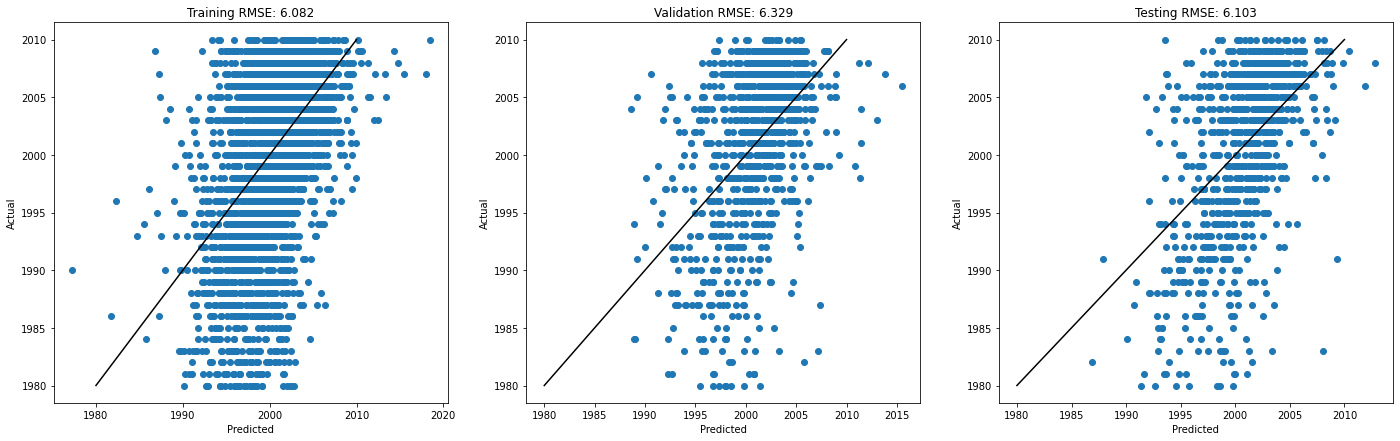

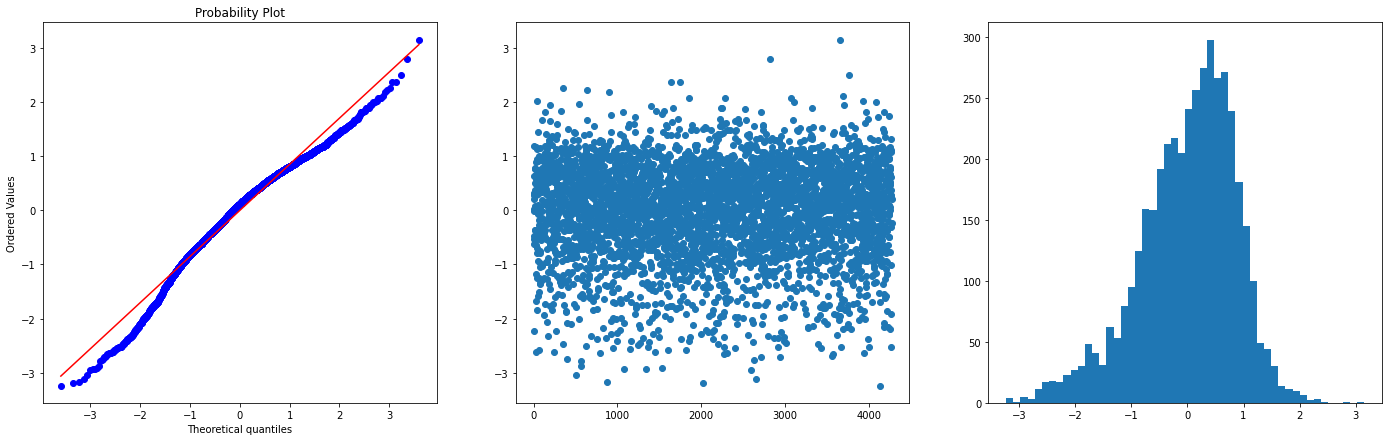

In [27]:
plot_predictions(linear_model_fm, X_train_std_fm, y_train_80s_90s_and_the_new_stuff, \
                 X_val_std_fm, y_val_80s_90s_and_the_new_stuff, \
                 X_test_std_fm, y_test_80s_90s_and_the_new_stuff, y_scaler_fm)
plot_residuals(linear_model_fm.resid)

Looking at the above, we've not fixed everything. But:
* The qq-plot does look better, our residuals are no longer heavily skewed - this has happened as a result of removing the outliers.
* Our model still isn't very acccurate, and is still mostly putting things in the 1990-2005 range. The results just look a bit better because we got rid of all those crazy outliers that are pre-1980 music. It's worth remembering what we saw in the correlation heat map, that there wasn't strong correlation between the predictors and our response.

With that in mind, let's park the linear regression and explore our regularised options.

## Ridge Regression

Let's throw some regularisation at this now. 

As with the first problem, I'm going to consider conduct two searches here. I'll start with a coarse search, and then conduct a finer search around that location.

My first search will move in increments of `step_size` to select some semi-optimal lambda. Having found that, I'll do second search around this initial optimal value +/-`step_size`. As such, in my first search I'll start at `step_size` rather than 0. This way, I don't find the optimal value in the first search as 0, and then try to include negative values in my search for lambda in the second search. This approach will still allow 0 to be considered in the fine-grained search.

Initial Alpha: 0.060000; Final Alpha: 0.054900


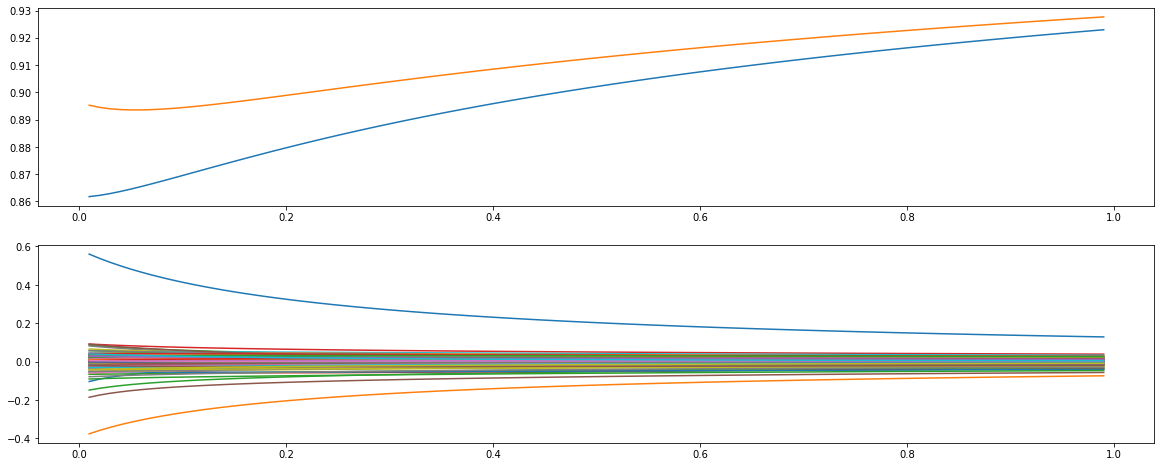

In [28]:
# setup search ranges, coarse search first
min_alpha = 0.01
max_alpha = 1
alpha_step = 0.01
alphas = numpy.arange(min_alpha, max_alpha, alpha_step)

# conduct coarse search
initial_ridge_model, train_rmse, val_rmse, coeffs, alpha_init = \
    fit_regularised(X_train_std_fm, y_train_std_fm, X_val_std_fm, y_val_std_fm, alphas, 0)
# draw some pictures
plot_regularised(alphas, train_rmse, val_rmse, coeffs)

# fine-grained search
# setup search range, take search around the initial estimate in a much finer grained search
alphas = numpy.arange(alpha_init - alpha_step, alpha_init + alpha_step, alpha_step / 100.0)
# do the search
final_ridge_model, train_rmse, val_rmse, coeffs, alpha = \
    fit_regularised(X_train_std_fm, y_train_std_fm, X_val_std_fm, y_val_std_fm, alphas, 0)
print('Initial Alpha: %f; Final Alpha: %f' % (alpha_init, alpha))

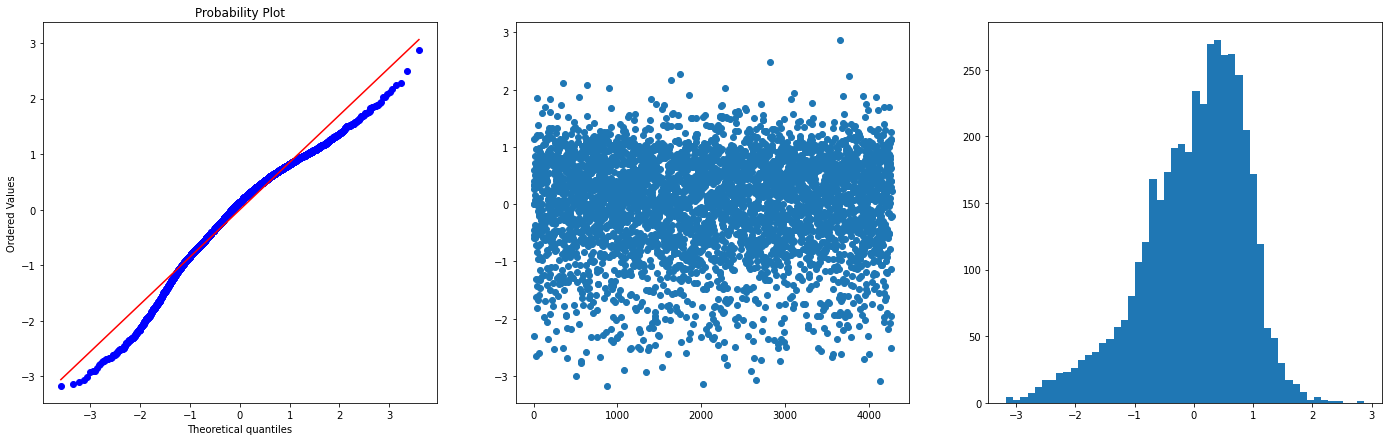

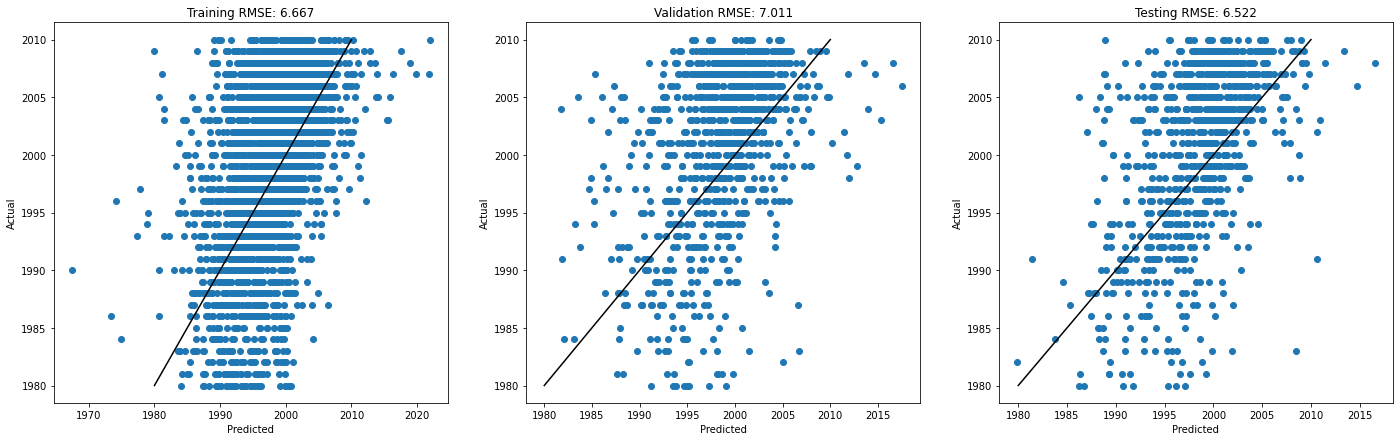

In [29]:
plot_residuals(y_train_std_fm.reshape(-1) - final_ridge_model.predict(X_train_std_fm).reshape(-1))
plot_predictions(final_ridge_model, X_train_std_fm, y_train_80s_90s_and_the_new_stuff, \
                 X_val_std_fm, y_val_80s_90s_and_the_new_stuff, \
                 X_test_std_fm, y_test_80s_90s_and_the_new_stuff, y_scaler)

Ridge has improved our model a little bit, though not massivley. Let's try LASSO.

## LASSO Regularisation

We'll take the exact same approach that we used for Ridge. All we need to do is change the `L1_wt` that we pass into our regularisation function.

Initial Alpha: 0.002000; Final Alpha: 0.001920


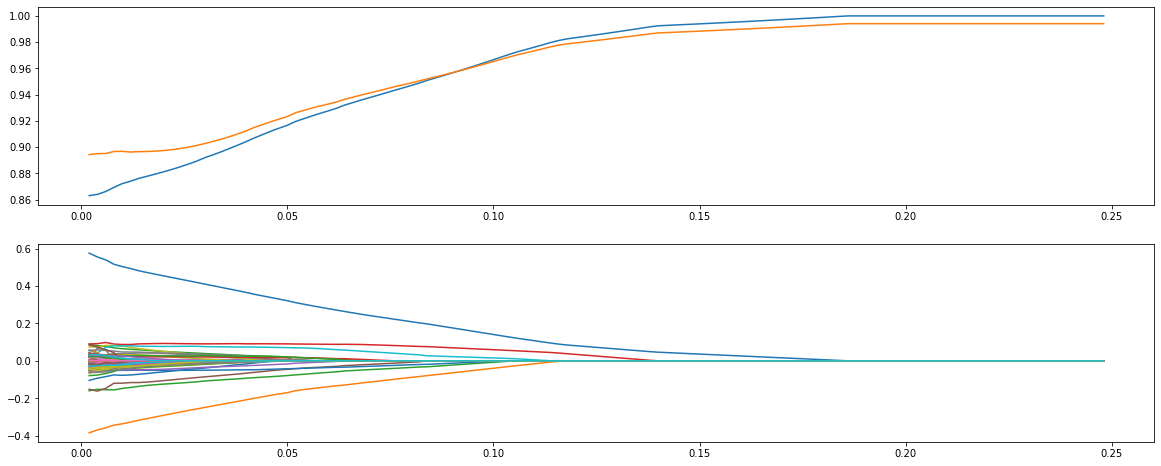

In [30]:
min_alpha = 0.002
max_alpha = 0.25
alpha_step = 0.002
alphas = numpy.arange(min_alpha, max_alpha, alpha_step)

initial_lasso_model, train_rmse, val_rmse, coeffs, alpha_init = \
    fit_regularised(X_train_std_fm, y_train_std_fm, X_val_std_fm, y_val_std_fm, alphas, 1)
plot_regularised(alphas, train_rmse, val_rmse, coeffs)

alphas = numpy.arange(alpha_init - alpha_step, alpha_init + alpha_step, alpha_step / 100.0)
final_lasso_model, train_rmse, val_rmse, coeffs, alpha = \
    fit_regularised(X_train_std_fm, y_train_std_fm, X_val_std_fm, y_val_std_fm, alphas, 1)
print('Initial Alpha: %f; Final Alpha: %f' % (alpha_init, alpha))

In [31]:
print('The LASSO model has %d terms removed' % sum(final_lasso_model.params == 0))

The LASSO model has 22 terms removed


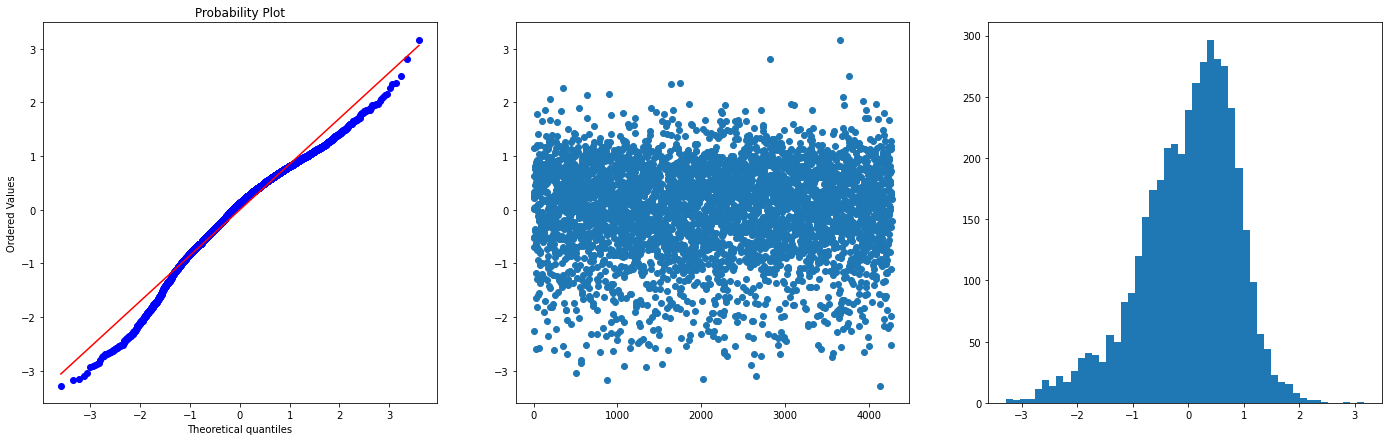

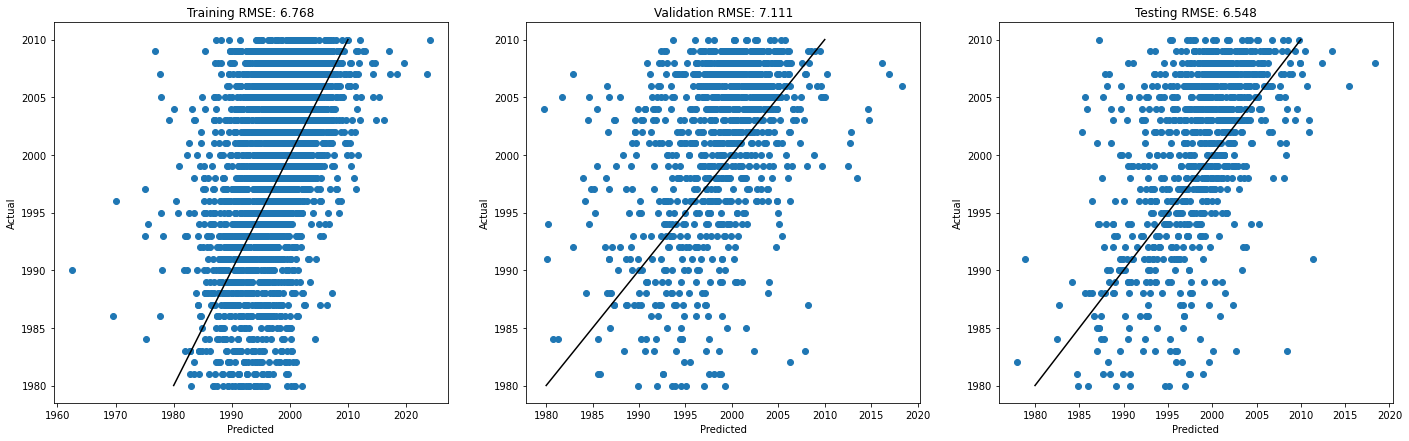

In [32]:
plot_residuals(y_train_std_fm.reshape(-1) - final_lasso_model.predict(X_train_std_fm).reshape(-1))
plot_predictions(final_lasso_model, X_train_std_fm, y_train_80s_90s_and_the_new_stuff, \
                 X_val_std_fm, y_val_80s_90s_and_the_new_stuff, \
                 X_test_std_fm, y_test_80s_90s_and_the_new_stuff, y_scaler)

We've removed a bunch of terms from the model, yet still don't have great accuracy. We're getting small improvements with regularisation, but it's not dramatic. 

As for why this is happening, remember again what we saw with the correlation values - we simply didn't have strong correlation between the predictors and the response. We are trying to model a linear relationship where one may not really exist.

## Deep Learning

In the first problem deep learning worked way better. Let's see what happens here. Note that:
* Again we're not using any convolutions. This data is tabular data, so we don't have the sort of spatial relationships between consecutive elements like we do in an image or an audio signal.
* We're using just the small segment of the data that we extracted earlier. The DNN could do a much better job leveraging the large dataset than the other methods, but in the interest of fairness (and avoiding the 400mb csv file) we'll stick to the small data.
* The network design is fairly arbitrary. Feel free to play with the layer sizes, number of layers, activations, use of batch normalisation or dropout. 

In [33]:
# input, 90 dimensional vectors
inputs = keras.Input(shape=(90, ), name='inp')
# 3 hidden layers, with 128, 256, and 128 neurons. We're looking to discover patterns/relationships in the data.
# more layers allows us to capture more complex relationships, but increases the risk of overfitting
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
# output layer
outputs = layers.Dense(1)(x)

# build the model and print a summary
model_dnn = keras.Model(inputs=inputs, outputs=outputs, name='song_prediction')
model_dnn.summary()

Model: "song_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 90)]              0         
                                                                 
 dense_4 (Dense)             (None, 128)               11648     
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 77,697
Trainable params: 77,697
Non-trainable params: 0
_________________________________________________________________


In [34]:
# train the model
model_dnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())

history = model_dnn.fit(X_train_std_fm, y_train_std_fm,
                    batch_size=64,
                    epochs=20,
                    validation_data=(X_val_std_fm, y_val_std_fm))

Epoch 1/20
67/67 [==============================] - 1s 8ms/step - loss: 0.9566 - val_loss: 0.8653
Epoch 2/20
67/67 [==============================] - 0s 5ms/step - loss: 0.7356 - val_loss: 0.7890
Epoch 3/20
67/67 [==============================] - 0s 6ms/step - loss: 0.6217 - val_loss: 0.7741
Epoch 4/20
67/67 [==============================] - 0s 6ms/step - loss: 0.5414 - val_loss: 0.8016
Epoch 5/20
67/67 [==============================] - 0s 6ms/step - loss: 0.4866 - val_loss: 0.8313
Epoch 6/20
67/67 [==============================] - 0s 6ms/step - loss: 0.3981 - val_loss: 0.8642
Epoch 7/20
67/67 [==============================] - 0s 6ms/step - loss: 0.3533 - val_loss: 0.8742
Epoch 8/20
67/67 [==============================] - 0s 6ms/step - loss: 0.3047 - val_loss: 0.9297
Epoch 9/20
67/67 [==============================] - 0s 6ms/step - loss: 0.2457 - val_loss: 0.9386
Epoch 10/20
67/67 [==============================] - 0s 6ms/step - loss: 0.2127 - val_loss: 0.9102
Epoch 11/20
67/67 [

30/30 [==============================] - 0s 2ms/step


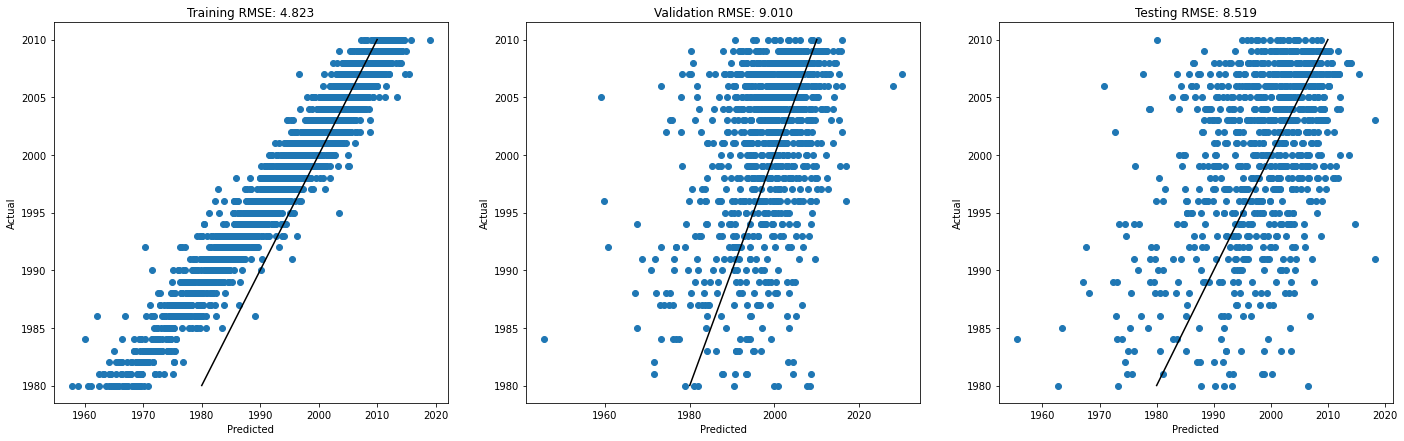

In [35]:
plot_predictions(model_dnn, X_train_std_fm, y_train_80s_90s_and_the_new_stuff, \
                 X_val_std_fm, y_val_80s_90s_and_the_new_stuff, \
                 X_test_std_fm, y_test_80s_90s_and_the_new_stuff, y_scaler)

One totally unsurprising observation is that we've overfit. This is expected for a few reasons:
* We have a small dataset.
* We're not doing anything to mitigate that small dataset. Fine-tuning and augmentation for example aren't options here, and we've got nothing in the network (like dropout, batch-norm, or weight regularisation) to help.
* We've got a lot of parameters. Our model might look small, it's just a few simple dense layers after all, but these layers are very parameter heavy.

With that in mind, let's re-train but stop training much, much quicker.

In [36]:
inputs = keras.Input(shape=(90, ), name='inp')
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)

# build the model and print a summary
model_dnn = keras.Model(inputs=inputs, outputs=outputs, name='mnist_angles_cnn_model')

# train the model
model_dnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())

history = model_dnn.fit(X_train_std_fm, y_train_std_fm,
                    batch_size=64,
                    epochs=2,
                    validation_data=(X_val_std_fm, y_val_std_fm))

Epoch 1/2
67/67 [==============================] - 1s 7ms/step - loss: 0.9307 - val_loss: 0.8044
Epoch 2/2
67/67 [==============================] - 0s 6ms/step - loss: 0.7066 - val_loss: 0.8185


30/30 [==============================] - 0s 2ms/step


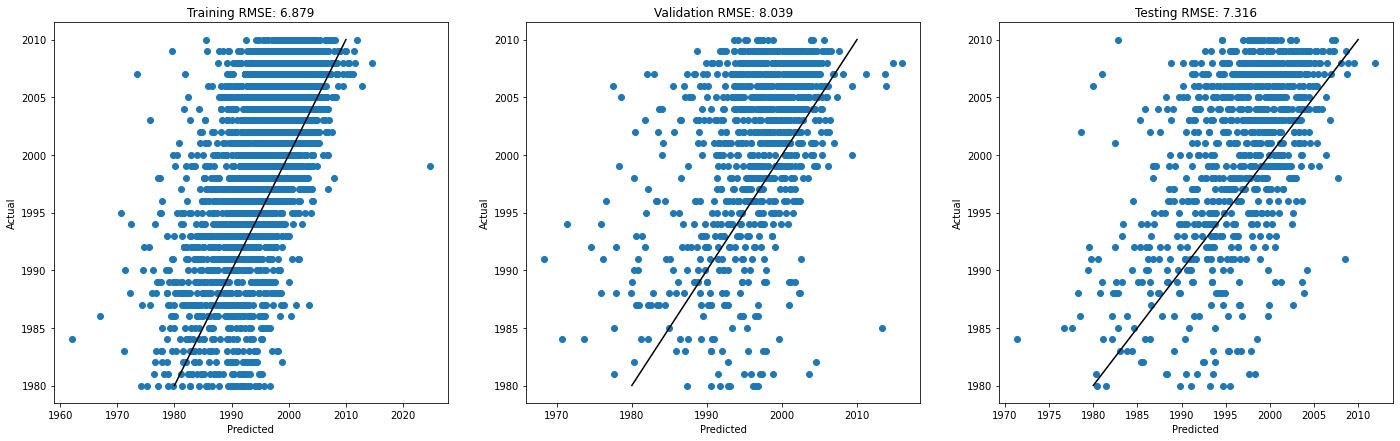

In [37]:
plot_predictions(model_dnn, X_train_std_fm, y_train_80s_90s_and_the_new_stuff, \
                 X_val_std_fm, y_val_80s_90s_and_the_new_stuff, \
                 X_test_std_fm, y_test_80s_90s_and_the_new_stuff, y_scaler)

We've managed to stop before we've overfit, but our predictions are back to being ordinary. 

So, we've trained a bunch of models now and all of them are fairly rubbish. Where is the hope? It's worth reflecting on the correlations we saw between the predictors and responses. To make those reflections easier, I'll repeat that plot here.

<AxesSubplot:>

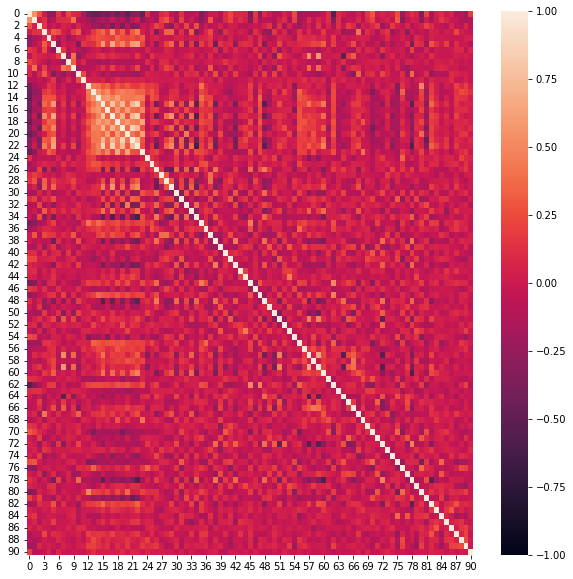

In [38]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
# concat X and y so that we get correlations between pairs of predictors, and correlations between 
# predictors and the response. As we've put these in the order [x, y], our correlations with the
# response will be the last column and row
seaborn.heatmap(numpy.corrcoef(numpy.hstack([X_train_std_fm, y_train_std_fm]).transpose()), ax=ax, vmin=-1.0, vmax=1.0)

I've changed the above to use the commercial FM radio-approved version of the data, but it shows much the same as we saw before, **there is not much of a linear relationship between the predictors and the response** (remember the response is shown in the last row/column). 

This lack of relationship is a problem. The deep net has helped a little bit as it can capture non-linear relationships, but we're hindered by small amounts of data here.

So what is the moral of all this? In summary, linear regression needs a linear relationship - and this isn't always present. If we wanted to improve this further, options would include:
* Go back to the original dataset and grab more data. This would help the DNN, but may also benefit other models.
* Consider if higher order terms should be included. This is most relevent for the linear regression models (and their regularised counterparts), as the DCNN can learn combinations of features though the multiple layers.
* Go further back to the raw audio data, and look at a different feature representation from that. **This point is well outside the scope of this example**, but there's no guarantee that the features that we're using are the best for this task.
* Reconsider the problem formulation. I've set this up as a regression task (regress from song properties to year of release), but is this appropriate? Shoudl this be a classification task for example? Often with ML there are multiple ways to approach a problem, some approaches may work better than others. Here, a classification task (perhaps by decade, or by five-year block?) may be better. **Again, this is really outside the scope of this example.**